# Histopathologic Cancer Detection

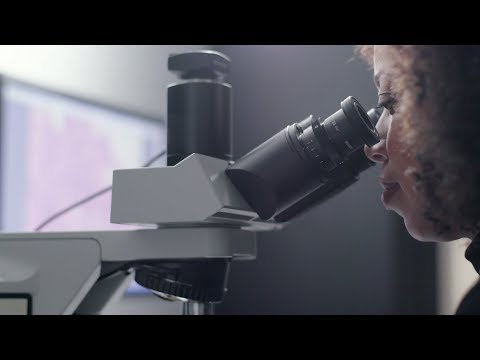

In [10]:
from IPython.display import Audio,Image, YouTubeVideo
id='9Mz84cwVmS0'
YouTubeVideo(id=id,width=1000,height=600)

In this challenge you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

This ia a Kaggle challenge, you can find it [here](https://www.kaggle.com/c/histopathologic-cancer-detection)

**Kaggle** is an online community of data scientists and machine learners, owned by Google, Inc. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

**Sections of this kernel**
- Project understanding
- Data understanding
- Data visualization
- Baseline model
- Validation and analysis
    - Metrics
    - Prediction visualizations
    - Confusion matrix
    - ROC & AUC
- Submit

---------------------------------------------------
# Project understanding
###  What exactly is the problem?

**Binary image classification problem.** Identify the presence of metastases from 96 x 96px digital histopathology images. One key challenge is that the metastases can be as small as single cells in a large area of tissue.

### How would a solution look like?

**Our evaluation metric is [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic).** The ROC curve is a plot of *True positive rate* against *False positive rate* at various thresholds and the area under the curve (AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The best possible solution would yield an AUC of 1 which means we would classify all positive samples correctly without getting any false positives. 

<img src="image2.png">

![ROC curve example](https://i.ibb.co/mBKh6ZB/roc.png)
<p style="text-align: center;"> ROC curve from a previous run of this kernel </p>

### What is known about the domain?

**The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).** This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

**Low-resolution**             | **Mid-resolution**            | **High-resolution** 
:-------------------------:|:-------------------------:|:-------------------------:
![](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_low_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_mid_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_high_resolution.png)
**[<p style="text-align: center;"> Example of a metastatic region in lymph nodes, CHAMELYON17 </p>](https://camelyon17.grand-challenge.org/Background/)**

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.

**Useful links for background knowledge**
- [Patch Camelyon (PCam)](https://github.com/basveeling/pcam)
- [Hematoxylin and eosin staining of tissue and cell sections](https://www.ncbi.nlm.nih.gov/pubmed/21356829)
- [H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)
- [CAMELYON16 - background](https://camelyon16.grand-challenge.org/Background/)
- [CAMELYON17 - background](https://camelyon17.grand-challenge.org/Background/)
- [TNM classification](https://www.uicc.org/resources/tnm)

----------------------------------------------
# Data understanding
### What data do we have available?

**220k training images and 57k evaluation images.** The dataset is a subset of the [PCam dataset](https://github.com/basveeling/pcam) and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the [Camelyon16 Challenge dataset](https://camelyon16.grand-challenge.org/Data/) which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.

According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, **the training distribution seems to be 60/40 (negatives/positives)**. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. **Tumor tissue in the outer region of the patch does not influence the label.** This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

**Image file descriptors**

Description | 
:--------:|:-------:
Format | TIF
Size | 96 x 96
Channels | 3
Bits per channel | 8
Data type | Unsigned char
Compression | Jpeg

### Is the data relevant to the problem?

This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases. However, some relevant information about the surroundings might be left out with these small-sized image samples.

### Is it valid? Does it reflect our expectations?

According to the data description, the dataset has been stripped of duplicates. However, this has not been confirmed by testing.

> For the entire dataset, when the slide-level label was unclear during the inspection of the H&E-stained slide, an additional WSI with a consecutive tissue section, immunohistochemically stained for cytokeratin, was used to confirm the classification.
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

### Is the data quality, quantity, recency sufficient?

> All glass slides included in the CAMELYON dataset were part of routine clinical care and are thus of diagnostic quality. However, during the acquisition process, scanning can fail or result in out-of-focus images. As a quality-control measure, all slides were inspected manually after scanning. The inspection was performed by an experienced technician (Q.M. and N.S. for UMCU, M.H. or R.vd.L. for the other centers) to assess the quality of the scan; when in doubt, a pathologist was consulted on whether scanning issues might affect diagnosis.
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

-----------------------------------------
# Data visualization

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle

data = pd.read_csv('train_labels_part.csv')
train_path = 'train/'
test_path = 'test/'
# quick look at the label stats
data.describe()

label
count  11.000000
mean    0.545455
std     0.522233
min     0.000000
25%     0.000000
50%     1.000000
75%     1.000000
max     1.000000

We can see that the negative/positive ratio is not entirely 50/50 as the label mean is well below 0.5. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.

### Plot some images with and without cancer tissue for comparison

In [3]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

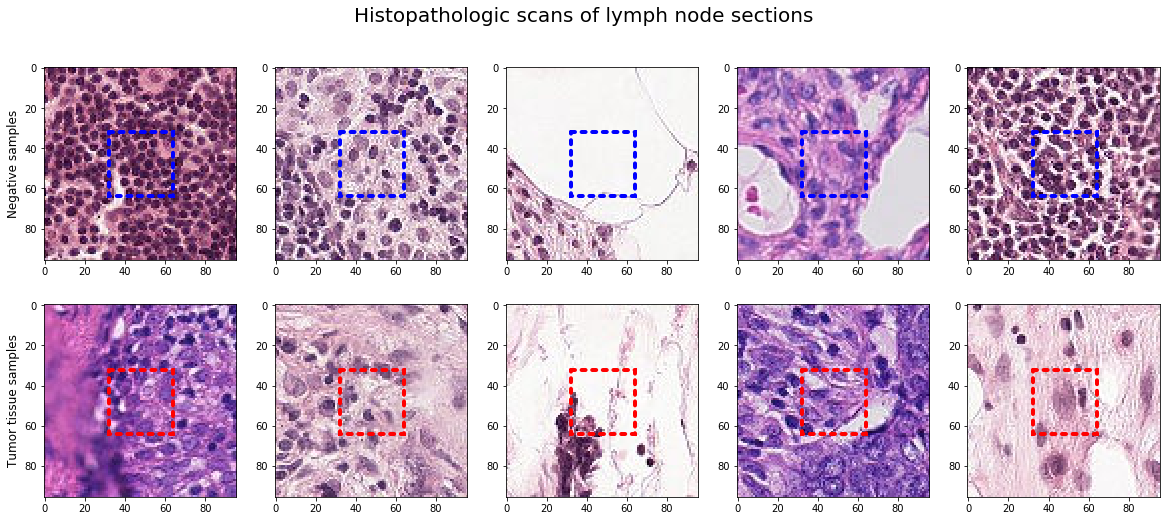

In [4]:
# random sampling
%matplotlib inline

shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), lymph node metastases can have these features:

> - Foreign cell population - key feature (Classic location: subcapsular sinuses)
- Cells with cytologic features of malignancy
    - Nuclear pleomorphism (variation in size, shape and staining).
    - Nuclear atypia:
        - **Nuclear enlargement**.
        - **Irregular nuclear membrane**.
        - **Irregular chromatin pattern, esp. asymmetry**.
        - **Large or irregular nucleolus**.
     - Abundant mitotic figures.
- Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation.
    - Gland formation.
    - Single cells.
    - Small clusters of cells.
  
**The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.**

### How is the data best transformed for modeling?

We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close.  This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.

### How may we increase the data quality?

We could inspect if the data contains bad data (too unfocused or corrupted) and remove those to increase the overall quality. 

### Preprocessing and augmentation
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. 

**The augmentations we can use for this type of data:**
- random rotation
- random crop
- random flip (horizontal and vertical both)
- random lighting
- random zoom (not implemented here)
- Gaussian blur (not implemented here)

We will use OpenCV with image operations because in my experience, OpenCV is a lot faster than *PIL* or *scikit-image*.

In [5]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 68          # final size after crop
RANDOM_ROTATION = 180   # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 4        # center crop shift in x and y axes, 0=no change
RANDOM_BRIGHTNESS = 5   # range (0-100), 0=no change
RANDOM_CONTRAST = 5     # range (0-100), 0=no change

def readCroppedImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)  
    M = cv2.getRotationMatrix2D((48,48),rotation,1)
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

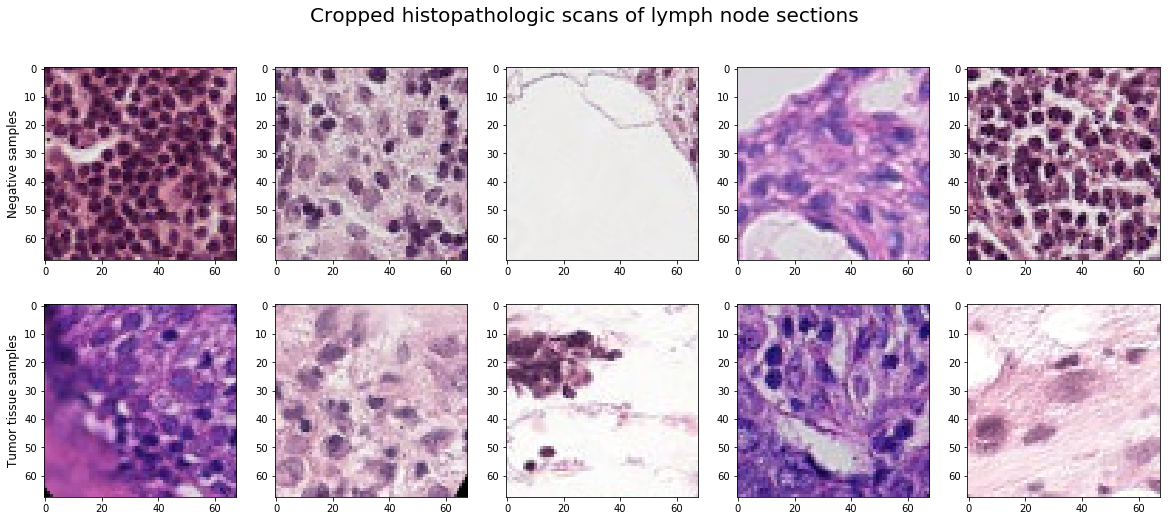

In [6]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

**To see the effects of our augmentation, we can plot one image multiple times.**

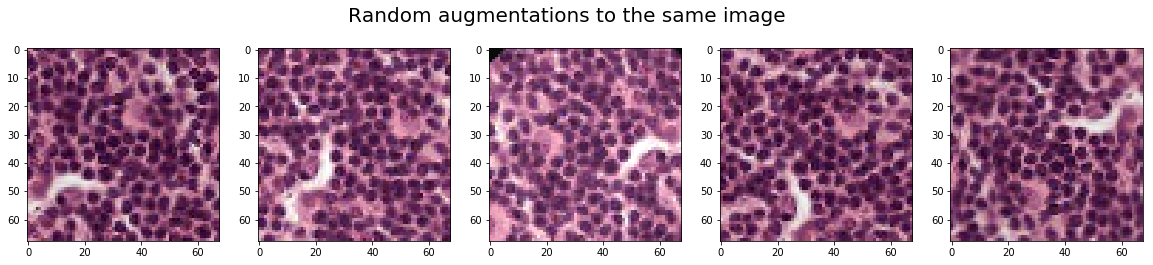

In [7]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

# Baseline model
In ML production pipeline, it is a good idea to start with a relatively simple model, sort of a minimum viable product (MVP) or a baseline. With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.

### What kind of model architecture suits the problem best?

Here we will be using a pretrained convnet model and transfer learning to adjust the weights to our data. Going for a deeper model architecture will start overfitting faster.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import os

/Users/margaritagubanova/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
train_df = pd.read_csv("train_labels_part.csv")
train,valid = train_test_split(train_df, test_size=0.3)

In [5]:
num_classes = 2
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
model.add(Dense(num_classes, activation='softmax'))
model.layers[0].trainable = False

In [40]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = 224
train_datagen = ImageDataGenerator(preprocess_input)
validation_datagen = ImageDataGenerator(preprocess_input)

In [44]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='../train/',
    x_col='id',
    y_col='label',
    has_ext=False,
    shuffle=True
    )

Found 0 images belonging to 2 classes.


In [45]:
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=valid,
    directory='../train/',
    x_col='id',
    y_col='label',
    has_ext=False,
    shuffle=False
)

Found 0 images belonging to 2 classes.


In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=10,
                    validation_data=validation_generator,
                    validation_steps=10,
                    epochs=13)

Epoch 1/13


In [ ]:
from glob import glob
from skimage.io import imread

base_test_dir = '../test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions[:,1]
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

# submission.to_csv("submission.csv", index = False, header = True)

In [ ]:
predictions

-------------------------
# Validation and analysis
Now the training is done.

### How good does the model perform technically?

We can only get metrics from our validation set, and the final test metrics will be most likely a bit different.
Loss? Accuracy?

### How good is the model in terms of project requirements?
It is a good idea to look at examples of images from:

- The most correctly labeled (highest probability)
- The most incorrectly labeled (highest probability but wrong label)
- The most uncertain labels (probability closest to 0.5).

The visualization is a good way of understanding where our model performs well and what are the images it struggles with. It might also reveal something about the dataset such as bad quality data.


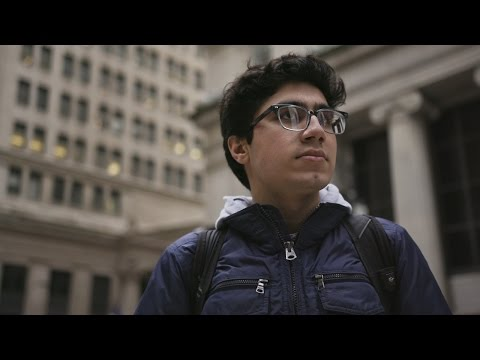

In [23]:
from IPython.display import Audio,Image, YouTubeVideo
id='El4OCwR6qxo'
YouTubeVideo(id=id,width=1000,height=600)